In [1]:
import pandas as pd
from BIKNN import BIKNN

In [2]:
# train = pd.read_csv( 'data/u1.base', sep = '\t', header = None )
# train = train.iloc[ :, 0:3 ]
# test  = pd.read_csv( 'data/u1.test', sep = '\t', header = None )
# test  = train.iloc[ :, 0:3 ]

In [3]:
data = pd.read_csv( 'test_data.txt', sep = ',', header = None )
data.head(4)

,0,1,2
0,1,1,1
1,1,2,2
2,1,3,5
3,2,1,2


In [4]:
# movie_lens = BIKNN( K = 5, B1 = 10, B2 = 10 )
# movie_lens.fit( data = data, columns = [ 'user_id', 'item_id', 'ratings' ] )

In [5]:
dict1 = { 
    'user_id': [6, 5],
    'item_id': [1, 2],
    'ratings': [5, 2]
}
test1 = pd.DataFrame( dict1, columns = [ 'user_id', 'item_id', 'ratings' ] )
test1

,user_id,item_id,ratings
0,6,1,5
1,5,2,2


In [6]:
# mae = movie_lens.update( test1, iterations = 10 )
# mae

In [9]:
from meta import ga

ga1 = ga( 
    pop_size = 15, 
    chromo_len = 2, 
    lower_bound = 0, 
    upper_bound = 100,
    retain = 0.5, 
    mutate = 0.2, 
    generation = 5,
    K = 10,
    data = data,
    columns = [ 'user_id', 'item_id', 'ratings' ],
    test = test1,
    iterations = 1000
)
print(ga1)

iteration 1's best generation: generation_info(cost=1.0509664813250679, chromo=[93, 8])
iteration 2's best generation: generation_info(cost=1.0509664813250679, chromo=[93, 8])
iteration 3's best generation: generation_info(cost=1.0509664813250679, chromo=[93, 8])
iteration 4's best generation: generation_info(cost=1.0509664813250679, chromo=[93, 8])
iteration 5's best generation: generation_info(cost=1.0509664813250679, chromo=[93, 8])
[generation_info(cost=1.0509664813250679, chromo=[93, 8]), generation_info(cost=1.0509664813250679, chromo=[93, 8]), generation_info(cost=1.0509664813250679, chromo=[93, 8]), generation_info(cost=1.0509664813250679, chromo=[93, 8]), generation_info(cost=1.0509664813250679, chromo=[93, 8])]


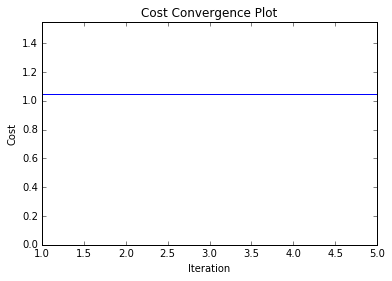

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

costs = [ ga.cost for ga in ga1 ]
plt.plot( range( 1, len(ga1) + 1 ), costs )
plt.title( 'Cost Convergence Plot' )
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.ylim( 0, costs[0] + 0.5 )
plt.show()